In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Dense, Reshape
from keras.models import Model
from keras.models import Model, Sequential
from keras.layers import (Activation, BatchNormalization, Concatenate, Dense, Dropout, Flatten, Input, Lambda, Reshape)
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from functools import partial
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report
# from tensorflow.keras import models, layers
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers

In [ ]:
# Load and Rescale the data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)


4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
# build cnn to classify fashion dataset
# Reshape the data to include channel dimension (required for Conv2D)
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)
X_val = X_val.reshape(-1, 28, 28, 1)

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
y_val = to_categorical(y_val, 10)


# Building the CNN Model

In [ ]:
# # model 2 496
# DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size = 3, padding = "same",activation ="relu", kernel_initializer='he_normal')
# model_2 = tf.keras.Sequential([
#     DefaultConv2D(filters=64, kernel_size=7, input_shape=[28,28,1]),
#     tf.keras.layers.MaxPool2D(),
#     DefaultConv2D(filters=128),
#     DefaultConv2D(filters=128),
#     tf.keras.layers.MaxPool2D(),
#     DefaultConv2D(filters=256),
#     DefaultConv2D(filters=256),
#     tf.keras.layers.MaxPool2D(),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(units=64, activation='relu', kernel_initializer='he_normal'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(units=10, activation='softmax')

# ])
# model_2.summary()

In [ ]:
# cnn_model = models.Sequential()

# cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
# cnn_model.add(layers.MaxPool2D(pool_size=(2, 2)))

# cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# cnn_model.add(layers.MaxPool2D(pool_size=(2, 2)))

# cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# cnn_model.add(layers.Flatten())

# # Each fully connected has half its input as its number of neurons.
# cnn_model.add(layers.Dense(250, activation='relu'))
# cnn_model.add(layers.Dense(125, activation='relu'))
# cnn_model.add(layers.Dense(60, activation='relu'))

# # 10 neurons in the last layer as we have 10 classes.
# cnn_model.add(layers.Dense(10, activation='softmax'))

# cnn_model.summary()

# # Compile the model
# cnn_model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])



# # Define callbacks
# callbacks = [
#     EarlyStopping(patience=10, restore_best_weights=True),
#     ModelCheckpoint("model.h5", save_best_only=True),
#     ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)
# ]
# # Compile the model
# cnn_model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
# # Train the model
# history = cnn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks= callbacks)


# Adding generated images to the CNN using DCGAN

In [ ]:
coding_size = 100

generator = tf.keras.Sequential([
    tf.keras.layers.Dense(7*7*128),
    tf.keras.layers.Reshape([7,7,128]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding='same', activation='tanh'),

])


discriminator = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding='same', activation= tf.keras.layers.LeakyReLU(0.2)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding='same', activation= tf.keras.layers.LeakyReLU(0.2)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1,activation='sigmoid')


])

gan = tf.keras.Sequential([generator,discriminator])

In [ ]:
# compile discriminator

discriminator.compile(loss = "binary_crossentropy", optimizer = "rmsprop")
#after compiling we put the discriminator we freeze the weights at this step as we want it to wrongly predict fake images and classify it as real
discriminator.trainable = False

gan.compile(loss='binary_crossentropy', optimizer='rmsprop')


In [ ]:
# incase of DCGAN we need to reshape and rescale to get 1 channel to match the training input with the generaeted img shape so we can concatenate(then we run the previous cell to iterate over the dataset)
X_train = X_train.reshape(-1,28,28,1)*2.-1.

In [ ]:
# we can't call the normal train function (fit method)
batch_size = 32
# we create a dataset to iterate over the images
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size=1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
def train_gan(gan, dataset, batch_size, coding_size, n_epochs):
    generator, discriminator = gan.layers

    for epoch in range(n_epochs):
          # for each batch in training set in each epoch
        for X_batch in dataset:
            # Phase 1: Train the discriminator

            #FAKE: RANDOM (GAUSSIAN DISTRIBUTION)
            noise = tf.random.normal(shape=[batch_size, coding_size])
            # 1-feed gaussian noise to generator to  generate fake images
            generated_imgs = generator(noise)

            # REAL: X_BATCH (FROM THE TRAINING DATASET)


            # CONCATENATE equal number of REAL 0 AND FAKE 1
            x_fake_and_real = tf.concat([generated_imgs, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(x_fake_and_real, y1)

            # Phase 2: Train the generator (we want to imporve the generator in this phase
            # so we want the discriminator to fail(wrongly classify fake as real))
            # thats why the target y2 is set to 1 although the images are fake (((((NOT TRAINABLE ALL FAKE!!!!)))))
            noise = tf.random.normal(shape=[batch_size, coding_size])
            y2 = tf.constant([[1.]] * batch_size)
            # we freeze the weights
            discriminator.trainable = False
            # feed the gan model random noise and its generator will try to produce fake images then its discriminator will try to guess whether its fake or real
            gan.train_on_batch(noise, y2)

# Train the GAN
train_gan(gan, dataset, batch_size, coding_size, n_epochs=50)

In [ ]:
generator.save("fashion_mnist_generator.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


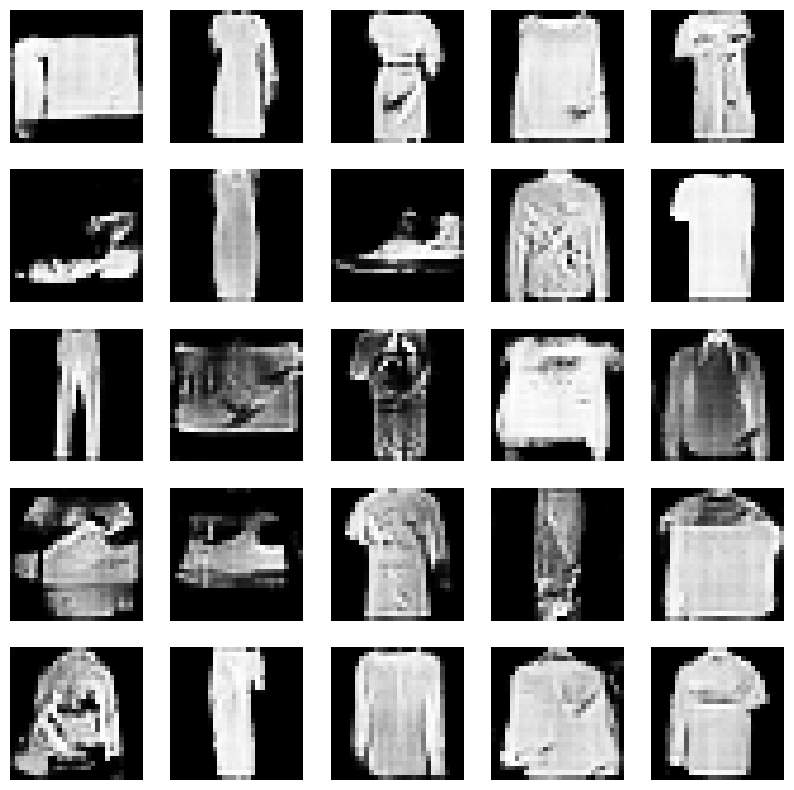

In [ ]:
def plot_generated_images(generator, n_images, coding_size):
    noise = tf.random.normal(shape=[n_images, coding_size])
    generated_images = generator(noise)
    generated_images = generated_images.numpy()

    plt.figure(figsize=(10, 10))
    for i in range(n_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(generated_images[i], cmap='gray')
        plt.axis('off')
    plt.show()

# Plot generated images
plot_generated_images(generator, n_images=25, coding_size=coding_size)

In [ ]:
# Function to generate images using the trained generator
def generate_images(generator, n_images, coding_size):
    noise = tf.random.normal(shape=[n_images, coding_size])
    generated_images = generator(noise)
    generated_images = (generated_images.numpy() + 1) / 2.0  # Rescaling
    return generated_images

In [ ]:
n_generated_images = 40000  # Number of images to generate
generated_images = generate_images(generator, n_generated_images, coding_size)

In [ ]:
# Combine the generated images with the original dataset
combined_X_train = np.concatenate([X_train, generated_images], axis=0)
combined_y_train = np.concatenate([y_train, y_train[:n_generated_images]], axis=0)

combined_X_train, combined_X_val, combined_y_train, combined_y_val = train_test_split(combined_X_train, combined_y_train, test_size=0.3, random_state=42)


In [ ]:
# Shuffle the combined dataset
train_indices = np.arange(combined_X_train.shape[0])
valid_indices = np.arange(combined_X_val.shape[0])

np.random.shuffle(train_indices)
np.random.shuffle(valid_indices)

combined_X_train = combined_X_train[train_indices]
combined_y_train = combined_y_train[train_indices]
combined_X_val = combined_X_val[valid_indices]
combined_y_val = combined_y_val[valid_indices]

#  CNN without DCGAN

In [ ]:

# # Build the CNN model
# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
#     MaxPooling2D((2, 2)),
#     Dropout(0.25),

#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Dropout(0.25),

#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.5),
#     Dense(10, activation='softmax')
# ])
# model.summary()

In [ ]:

# Define a partial function for Conv2D with BatchNormalization
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same", activation=None, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001))

model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(),

    DefaultConv2D(filters=128),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    DefaultConv2D(filters=128),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(),

    DefaultConv2D(filters=256),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    DefaultConv2D(filters=256),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation=None, kernel_initializer='he_normal'),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(units=64, activation=None, kernel_initializer='he_normal'),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(units=10, activation='softmax')
])

model.summary()


In [ ]:

# Define callbacks
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("model.h5", save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)
]
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks= callbacks)

# # Compile the model
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# # Train the model
# history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val))



In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')



In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()




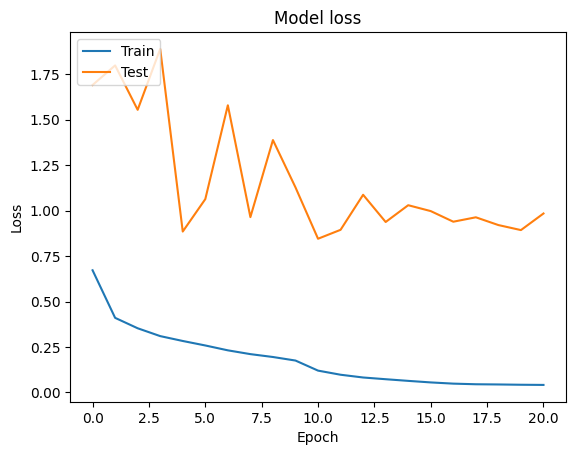

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Train the model with DCGAN


In [ ]:
# model p 496

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same", activation=None, kernel_initializer='he_normal')

gan_model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(),

    DefaultConv2D(filters=128),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    DefaultConv2D(filters=128),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(),

    DefaultConv2D(filters=256),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    DefaultConv2D(filters=256),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation=None, kernel_initializer='he_normal'),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(units=64, activation=None, kernel_initializer='he_normal'),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(units=10, activation='softmax')
])

gan_model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 64)        3200      
                                                                 
 batch_normalization_16 (Ba  (None, 28, 28, 64)        256       
 tchNormalization)                                               
                                                                 
 activation_14 (Activation)  (None, 28, 28, 64)        0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 batch_normalization_17 (Ba  (None, 14, 14, 128)      

In [ ]:

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("model.h5", save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)
]
# Compile the model
gan_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Train the model
gan_history = gan_model.fit(combined_X_train, combined_y_train, epochs=100, batch_size=32,validation_data=(combined_X_val, combined_y_val), callbacks= callbacks)



# Compile the model
# gan_model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# # Train the model
# gan_history = gan_model.fit(combined_X_train, combined_y_train, epochs=15, batch_size=32, validation_data=(combined_X_val, combined_y_val))





Epoch 1/100
1794/1794 [==============================] - 26s 12ms/step - loss: 1.5517 - accuracy: 0.4245 - val_loss: 1.3263 - val_accuracy: 0.4866 - lr: 0.0010
Epoch 2/100
1794/1794 [==============================] - 20s 11ms/step - loss: 1.3815 - accuracy: 0.4795 - val_loss: 1.2818 - val_accuracy: 0.5014 - lr: 0.0010
Epoch 3/100
1794/1794 [==============================] - 21s 12ms/step - loss: 1.3371 - accuracy: 0.4933 - val_loss: 1.2592 - val_accuracy: 0.5086 - lr: 0.0010
Epoch 4/100
1794/1794 [==============================] - 23s 13ms/step - loss: 1.3159 - accuracy: 0.4982 - val_loss: 1.2604 - val_accuracy: 0.5115 - lr: 0.0010
Epoch 5/100
1794/1794 [==============================] - 21s 12ms/step - loss: 1.2990 - accuracy: 0.5039 - val_loss: 1.2529 - val_accuracy: 0.5141 - lr: 0.0010
Epoch 6/100
1794/1794 [==============================] - 21s 12ms/step - loss: 1.2834 - accuracy: 0.5088 - val_loss: 1.2445 - val_accuracy: 0.5175 - lr: 0.0010
Epoch 7/100
1794/1794 [=================

# Evaluation and Comparison

In [ ]:
# Evaluate the model
test_loss_gan, test_acc_gan = gan_model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')



In [ ]:
# Plot training & validation accuracy values
plt.plot(gan_history.history['accuracy'])
plt.plot(gan_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()




In [ ]:
# Plot training & validation loss values
plt.plot(gan_history.history['loss'])
plt.plot(gan_history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()